# Model EfficientNetBO Contribution 2

In [1]:
!pip install efficientnet_pytorch opacus

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from opacus import PrivacyEngine
from efficientnet_pytorch import EfficientNet
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Déséquilibre artificiel
class_sizes = {0:5000, 1:4500, 2:4000, 3:3000, 4:2000, 5:1000, 6:800, 7:700, 8:600, 9:500}
class_indices = {i: torch.where(torch.tensor(trainset.targets)==i)[0] for i in range(10)}
imbalanced_indices = torch.cat([class_indices[i][:size] for i, size in class_sizes.items()])

train_subset = Subset(trainset, imbalanced_indices)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader  = DataLoader(testset, batch_size=32, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model_nodp = EfficientNet.from_pretrained('efficientnet-b0')
model_nodp._fc = nn.Linear(model_nodp._fc.in_features, 10)
model_nodp = model_nodp.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_nodp = optim.Adam(model_nodp.parameters(), lr=0.001)

# Entrainement Non-DP rapide (15 epochs)
for epoch in range(15):
    model_nodp.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_nodp.zero_grad()
        loss = criterion(model_nodp(images), labels)
        loss.backward()
        optimizer_nodp.step()



Loaded pretrained weights for efficientnet-b0


In [6]:
def convert_batchnorm_to_groupnorm(module):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            num_groups = max(1, min(8, num_channels))
            setattr(module, name, nn.GroupNorm(num_groups=num_groups, num_channels=num_channels))
        else:
            convert_batchnorm_to_groupnorm(child)
    return module

# Chargement du modèle EfficientNet-B0 et remplacement de BatchNorm
model_dp = EfficientNet.from_pretrained('efficientnet-b0')
model_dp._fc = nn.Linear(model_dp._fc.in_features, 10)

# Appliquer la conversion
model_dp = convert_batchnorm_to_groupnorm(model_dp)
model_dp = model_dp.to(device)

# Initialisation de l'optimiseur
optimizer_dp = optim.Adam(model_dp.parameters(), lr=0.001)

# Initialisation du Privacy Engine
privacy_engine = PrivacyEngine()
model_dp, optimizer_dp, train_loader = privacy_engine.make_private(
    module=model_dp,
    optimizer=optimizer_dp,
    data_loader=train_loader,
    noise_multiplier=0.6,
    max_grad_norm=1.0,
)

# Fonction de clipping adaptatif
def adaptive_clipping(label):
    size = class_sizes[label]
    return 1.0 if size >= 3000 else (3.0 if size >= 1000 else 5.0)

# Entrainement DP adaptatif
for epoch in range(15):
    model_dp.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        clip_vals = torch.tensor([adaptive_clipping(label.item()) for label in labels]).to(device)
        optimizer_dp.max_grad_norm = clip_vals.mean().item()
        optimizer_dp.zero_grad()
        loss = criterion(model_dp(images), labels)
        loss.backward()
        optimizer_dp.step()

    epsilon = privacy_engine.get_epsilon(delta=1e-5)
    print(f"Epoch {epoch+1}, ε: {epsilon:.2f}")



Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1, ε: 1.74
Epoch 2, ε: 2.01
Epoch 3, ε: 2.19
Epoch 4, ε: 2.34
Epoch 5, ε: 2.47
Epoch 6, ε: 2.58
Epoch 7, ε: 2.68
Epoch 8, ε: 2.78
Epoch 9, ε: 2.87
Epoch 10, ε: 2.96
Epoch 11, ε: 3.04
Epoch 12, ε: 3.12
Epoch 13, ε: 3.20
Epoch 14, ε: 3.28
Epoch 15, ε: 3.35


In [7]:
# Évaluation par classe
def evaluate_per_class(model, loader):
    model.eval()
    correct, total = torch.zeros(10), torch.zeros(10)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                total[labels[i]] += 1
                if predicted[i] == labels[i]:
                    correct[labels[i]] += 1
    return (correct / total * 100).numpy()

accuracy_nodp = evaluate_per_class(model_nodp, test_loader)
accuracy_dp = evaluate_per_class(model_dp, test_loader)

print("Accuracy per class:")
categories = ['Avion', 'Auto', 'Oiseau', 'Chat', 'Cerf', 'Chien', 'Grenouille', 'Cheval', 'Bateau', 'Camion']
for i in range(10):
    print(f"{categories[i]} - Non-DP: {accuracy_nodp[i]:.2f}% | DP adaptatif: {accuracy_dp[i]:.2f}%")


Accuracy per class:
Avion - Non-DP: 97.10% | DP adaptatif: 65.10%
Auto - Non-DP: 97.80% | DP adaptatif: 87.20%
Oiseau - Non-DP: 90.70% | DP adaptatif: 67.10%
Chat - Non-DP: 86.70% | DP adaptatif: 50.20%
Cerf - Non-DP: 84.30% | DP adaptatif: 10.90%
Chien - Non-DP: 78.90% | DP adaptatif: 0.00%
Grenouille - Non-DP: 89.80% | DP adaptatif: 3.50%
Cheval - Non-DP: 65.40% | DP adaptatif: 0.00%
Bateau - Non-DP: 76.20% | DP adaptatif: 0.00%
Camion - Non-DP: 85.20% | DP adaptatif: 0.00%


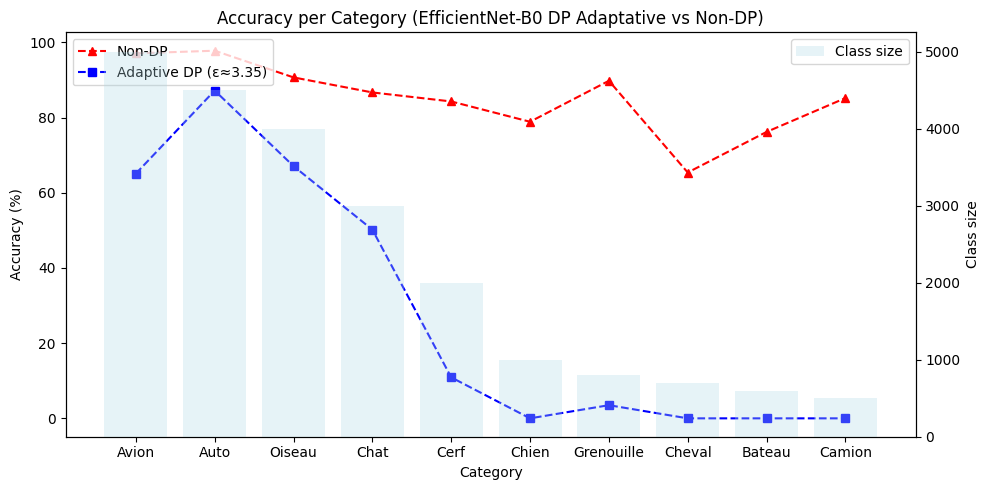

In [8]:
class_sizes_list = [class_sizes[i] for i in range(10)]

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot(categories, accuracy_nodp, 'r--^', label='Non-DP')
ax1.plot(categories, accuracy_dp, 'b--s', label='Adaptive DP (ε≈{:.2f})'.format(epsilon))

ax2.bar(categories, class_sizes_list, alpha=0.3, color='lightblue', label='Class size')

ax1.set_ylabel('Accuracy (%)')
ax2.set_ylabel('Class size')
ax1.set_xlabel('Category')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Accuracy per Category (EfficientNet-B0 DP Adaptative vs Non-DP)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
